# 07. Molecules CG Mapping 

In this tutorial, we show how to generate a CG mapping matrix for a molecule given a bead distribution. The trajectory and topology file come from a AA simulation done in gromacs (see `Molecules_CG_Mapping` folder). The protein is FF (diphenylalanine) and the solvent is a mixture of water and methanol.

In [1]:
# disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import hoomd, hoomd.htf as htf, hoomd.md
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import MDAnalysis as mda
from os import path
import pickle
import matplotlib.pyplot as plt,matplotlib

In [2]:
# Loading inputs
TPR = 'Molecules_CG_Mapping/nvt_prod.tpr'
tpr = mda.Universe(TPR)
TRAJECTORY = 'Molecules_CG_Mapping/traj.trr'
u = mda.Universe(TPR, TRAJECTORY)

# Generating Mapping Matrix for FF
protein_FF = u.select_atoms("resname PHE and resid 0:1")
Beads_distribution = [['N','H1','H2','H3'],
                     ['CA','HA','CB','HB1','HB2'],
                     ['CG','CD1','HD1','CD2','HD2','CE1','HE1','CE2','HE2','CZ','HZ'],
                     ['C','O'],
                     ['N','H'],
                     ['CA','HA','CB','HB1','HB2'],
                     ['CG','CD1','HD1','CD2','HD2','CE1','HE1','CE2','HE2','CZ','HZ'],
                     ['C','O1','O2']]
mapping_FF = htf.matrix_mapping(protein_FF,Beads_distribution)
print (mapping_FF)

/home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/MDAnalysis/core/universe.py:171: UserWarning: No coordinate reader found for Molecules_CG_Mapping/nvt_prod.tpr. Skipping this file.
  'this file.'.format(filename))


[[0.8224383  0.05918723 0.05918723 0.05918723 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.44409524 0.03726984
  0.44409524 0.03726984 0.03726984 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.15577257 0.15577257 0.01307

In [3]:
# Generating Mapping Matrix for Water
water = u.select_atoms("resname SOL and resid 500")
Beads_distribution = [['OW','HW1','HW2']]
mapping_water = htf.matrix_mapping(water,Beads_distribution)             
print (mapping_water)

[[0.88809574 0.05595213 0.05595213]]


In [4]:
# Generating Mapping Matrix for Methanol
methanol = u.select_atoms("resname MET and resid 11665 ")
Beads_distribution_methanol = [['C','H','H','H','OA','HO']]
mapping_methanol = htf.matrix_mapping(methanol,Beads_distribution_methanol)             
print (mapping_methanol)

[[0.37484707 0.03145832 0.03145832 0.03145832 0.49931966 0.03145832]]


In [5]:
# Getting the segment id of each molecule in topology
_,idx = np.unique(u.select_atoms('all').segids,return_index=True)
seg_id_list = u.select_atoms('all').segids[np.sort(idx)].tolist()

# Getting the list of every molecule type name in topology
_,idx = np.unique(u.atoms.resnames,return_index=True)
resname_list = u.atoms.resnames[np.sort(idx)].tolist()

# Getting list of atoms in each type of molecule
atoms_in_molecule_list = [protein_FF.names,
                          water.names,
                          methanol.names]

In [6]:
atoms_in_molecule_list = [protein_FF.names]
molecule_mapping_index = htf.find_molecules_from_topology(u,atoms_in_molecule_list, selection = "resname PHE")
molecule_mapping = mapping_FF

# get number of atoms
N = sum([len(m) for m in molecule_mapping_index])
# get number of molecules
M = len(molecule_mapping_index)
# get number of beads
B = molecule_mapping.shape[0]

#create a mass-weighted (M * bead_number) x N mapping operator 
cg_mapping = htf.sparse_mapping([molecule_mapping for _ in molecule_mapping_index], 
                                molecule_mapping_index)
assert cg_mapping.shape == (M * B, N)
print (M*B)

160


## Building the model graph

We build an LJ potential with unknown, trainable parameters (`epsilon`, `sigma`) which start out at 0.9 and 1.1. We then obtain forces from our potential and the simulation. Force matching is used to modify the LJ potential until the forces agree. We use Keras layers to implement the trainable parameters. We'll make our starting parameters $\epsilon=1.2$ and $\sigma=0.9$. The goal is train them to reach $\sigma, \epsilon = 1.0$

In [7]:
class LJLayer(tf.keras.layers.Layer):
    def __init__(self, sig, eps):
        super().__init__(self, name='lj')
        self.start = [sig, eps]
        self.w = self.add_weight(
            shape=[2],
            initializer=tf.constant_initializer([sig, eps]),
            constraint=tf.keras.constraints.NonNeg())

    def call(self, r):
        r6 = tf.math.divide_no_nan(self.w[1]**6, r**6)
        energy = self.w[0] * 4.0 * (r6**2 - r6)
        # divide by 2 to remove double count
        return energy / 2.
    
class TrainableLJ(htf.SimModel):
    def setup(self):
        self.lj = LJLayer(0.9, 1.2)

    def compute(self, nlist):
        # get r
        r = htf.safe_norm(tensor=nlist[:, :, :3], axis=2)
        p_energy = self.lj(r)
        energy = tf.reduce_sum(input_tensor=p_energy, axis=1)
        forces = htf.compute_nlist_forces(nlist, energy)
        return forces, self.lj.w, energy
    
class TrajModel(htf.SimModel):
    def setup(self):
        self.avg_chrdf = tf.keras.metrics.MeanTensor()
        self.avg_ohrdf = tf.keras.metrics.MeanTensor()
    def compute(self, nlist, positions):                
        # pairwise energy. Double count -> divide by 2
        inv_r6 = htf.nlist_rinv(nlist)**6
        p_energy = 4.0 / 2.0 * (inv_r6 * inv_r6 - inv_r6)
        # sum over pairwise energy
        energy = tf.reduce_sum(p_energy, axis=1)
        # get forces
        forces = htf.compute_nlist_forces(nlist, energy)
        
        # now get RDF
        # For reference, type indices in this case are: {C:0, H:1, N:2, O:3} 
        # compute C-H RDF
        chrdf = htf.compute_rdf(
            nlist, [0, 15], positions[:, 3], 
            nbins=20, type_i=0, type_j=1)
        # compute O-H RDF
        ohrdf = htf.compute_rdf(
            nlist,[0, 15],  positions[:, 3], 
            nbins=20, type_i=3, type_j=1)
        # average the RDFs
        self.avg_chrdf.update_state(chrdf)
        self.avg_ohrdf.update_state(ohrdf)
        return forces
    
# define model
class MappingModel(htf.SimModel):
    def setup(self, CG_NN, cg_mapping, rcut):
        self.CG_NN = CG_NN
        self.rcut = rcut
        self.cg_mapping = cg_mapping
        self.avg_cg_rdf = tf.keras.metrics.MeanTensor()
        self.avg_aa_rdf = tf.keras.metrics.MeanTensor()
    def compute(self, nlist, positions, box):
        # calculate the center of mass of a CG bead
        box_size = htf.box_size(box)
        mapped_pos = htf.center_of_mass(positions[:,:3], self.cg_mapping, box_size)
        # create the mapped neighbot list
        mapped_nlist = htf.compute_nlist(mapped_pos, self.rcut, self.CG_NN, box_size, True)
        # compute RDF for mapped and C-C in all-atom
        cg_rdf = htf.compute_rdf(mapped_nlist, [0.1,self.rcut])
        aa_rdf = htf.compute_rdf(nlist, [0.1,self.rcut], positions[:,3], type_i=3, type_j=3)
        self.avg_cg_rdf.update_state(cg_rdf)
        self.avg_aa_rdf.update_state(aa_rdf)
        return
# model = TrajModel(256)
    
class NlistNN(htf.SimModel):
    def setup(self, dim, top_neighs):
        self.dense1 = tf.keras.layers.Layer(dim)
        self.dense2 = tf.keras.layers.Layer(dim)
        self.last = tf.keras.layers.Layer(1)
        self.top_neighs = top_neighs

    def compute(self, nlist, positions, box, sample_weight):
        rinv = htf.nlist_rinv(nlist)
        # closest neighbors have largest value in 1/r, take top
        top_n = tf.sort(rinv, axis=1, direction='DESCENDING')[
            :, :self.top_neighs]
        # run through NN
        x = self.dense1(top_n)
        x = self.dense2(x)
        pair_energy = self.last(x)
        # get per-particle energy
        energy = tf.reduce_sum(pair_energy, axis=1)
        forces = htf.compute_nlist_forces(nlist, energy)
        # don't output last column of forces, pairwise energy, since it's meaningless here
        return forces[:,:3], energy    
    
    
max_neighbor_est = 128
map_model = MappingModel(
    max_neighbor_est, 
    CG_NN=max_neighbor_est, 
    cg_mapping=cg_mapping, 
    output_forces=False,
    rcut=10,
    check_nlist=True)
# print (u.trajectory.select_atoms('resname PHE'))

In [8]:
tfcompute = htf.tfcompute(map_model)


## Run from trajectory

We load the trajectory with `MDAnalysis` and then call the `iter_from_trajectory` command. It runs over the trajectory computing the graph and constructs neighborlists according to the r_cut. 

In [9]:
model = NlistNN(128, dim=16, top_neighs=8)
model.compile('Adam', ['MeanSquaredError', None])
losses = []
# u1 = mda.Merge(u.select_atoms())
for epoch in range(3):
    for inputs, ts in htf.iter_from_trajectory(128, u, selection='resname PHE', r_cut=10, period=1):
        #labels = ts.forces
        result = model(inputs)
        labels = ts.positions
        loss = model.train_on_batch(inputs, labels)
        losses.append(loss)
print (losses)

[[1713.921630859375, 1713.921630859375], [1713.921630859375, 1713.921630859375], [1713.921630859375, 1713.921630859375]]


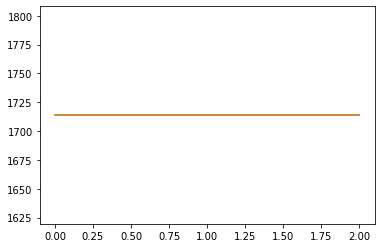

In [10]:
plt.plot(losses)
plt.show()

In [11]:
r_cut = 10
CG_NN=max_neighbor_est
for inputs, ts in htf.iter_from_trajectory(128, u,selection='resname PHE', r_cut=r_cut,period =20):
    print (ts)
    forces,energy = model(inputs)
    aa_pos = inputs[1].astype('float32')
    box = inputs[2].astype('float32')
    box_size = [box[0,0],box[0,0],box[0,0]]
#     box_size = htf.box_size(box)
    mapped_pos = htf.center_of_mass(aa_pos, cg_mapping, box_size)
    # create the mapped neighbor list
    mapped_nlist = htf.compute_nlist(mapped_pos, r_cut, CG_NN, box_size, True)
#     mapped_forces = htf.compute_nlist_forces(mapped_nlist, energy)
#     rinv = htf.nlist_rinv(mapped_nlist)
#     # closest neighbors have largest value in 1/r, take top
#     top_n = tf.sort(rinv, axis=1, direction='DESCENDING')[
#         :, :self.top_neighs]
#     # run through NN
#     x = self.dense1(top_n)
#     x = self.dense2(x)
#     pair_energy = self.last(x)
    
#     mapped_forces = ...
#     mapped_nlist = htf.compute_nlist(mapped_pos, ...)
#     model_inputs = [mapped_pos, mapped_nlist] + inputs[2:] # get box,  other items
#     loss = my_model.train_on_batch(x = model_inputs, y = mapped_forces)
#     print(loss)
print (forces)

< Timestep 0 with unit cell dimensions [0. 0. 0. 0. 0. 0.] >
tf.Tensor(
[[-0.75605094 -1.67521    -0.90831196]
 [ 2.4806285   0.41343102 -2.6850765 ]
 [-0.19071627 -0.45533967 -1.5195472 ]
 ...
 [ 0.3597199   0.55832905  0.5210553 ]
 [-1.1853663   0.7152859   2.0811496 ]
 [ 1.0954714   2.4486675  -0.24102783]], shape=(860, 3), dtype=float32)


In [12]:
for inputs, ts in htf.iter_from_trajectory(128, u,selection='resname PHE', r_cut=r_cut,period =20):
    forces,energy = model(inputs)
    aa_pos = inputs[1].astype('float32')
    box = inputs[2].astype('float32')
    box_size = [box[0,0],box[0,0],box[0,0]]
#     box_size = htf.box_size(box)
    mapped_pos = htf.center_of_mass(aa_pos, cg_mapping, box_size)
    # create the mapped neighbor list
    mapped_nlist = htf.compute_nlist(mapped_pos, r_cut, CG_NN, box_size, True)
#     mapped_forces = htf.compute_nlist_forces(mapped_nlist, energy)

In [13]:
class NlistNN(htf.SimModel):
    def setup(self, dim, top_neighs, cg_mapping, rcut, CG_NN):
        self.dense1 = tf.keras.layers.Layer(dim)
        self.dense2 = tf.keras.layers.Layer(dim)
        self.last = tf.keras.layers.Layer(1)
        self.top_neighs = top_neighs
        self.cg_mapping = cg_mapping
        self.CG_NN = CG_NN
        self.rcut = rcut

    def compute(self, nlist, positions, box, cg_mapping):
        # calculate the center of mass of a CG bead
        box_size = [box[0,0],box[0,0],box[0,0]]
        mapped_pos = htf.center_of_mass(positions[:,:3], self.cg_mapping, box_size)
        mapped_nlist = htf.compute_nlist(mapped_pos, self.rcut, self.CG_NN, box_size, True)
#         rinv_6 = htf.nlist_rinv(mapped_nlist)**6
#         # closest neighbors have largest value in 1/r, take top
#         top_n = tf.sort(rinv, axis=1, direction='DESCENDING')[
#             :, :self.top_neighs]
#         # run through NN
#         x = self.dense1(top_n)
#         x = self.dense2(x)
        def energy_lj(nlist):
            rinv_6 = htf.nlist_rinv(nlist)**6
            p_energy = 4.0 / 2.0 * (rinv_6 * rinv_6 - rinv_6)
            e = tf.reduce_sum(p_energy, axis=1)
            return e
        energy = energy_lj(nlist)
        # get per-particle energy
        mapped_energy =  energy_lj(mapped_nlist)
        forces = htf.compute_nlist_forces(nlist, energy)
        mapped_forces = htf.compute_nlist_forces(mapped_nlist, mapped_energy)
        nlist_grad = tf.gradients(energy, nlist)[0]
#         tf.print (mapped_nlist)
#         nlist_grad = tf.gradients(energy, mapped_nlist)[0]
#         mapped_forces = htf.compute_nlist_forces(mapped_nlist, energy)
        return forces[:,:3], energy, mapped_forces[:,:3], mapped_energy, mapped_pos, mapped_nlist   
model = NlistNN(128, dim=16, top_neighs=8, cg_mapping = cg_mapping, rcut = 10, CG_NN=max_neighbor_est )
model.compile('Adam', ['MeanSquaredError', None])

In [16]:
Total_energy = []
Total_mapped_energy = []
for inputs, ts in htf.iter_from_trajectory(128, u,selection='resname PHE', r_cut=r_cut,period =1):
    print (ts)
    forces,energy, mapped_forces, mapped_energy,mapped_pos, mapped_nlist = model(inputs)
    model_inputs = [mapped_pos, mapped_nlist] + inputs[2:] # get box,  other items
    Total_energy.append(np.sum(energy))
    Total_mapped_energy.append(np.sum(mapped_energy))
    loss = model.train_on_batch(x = model_inputs, y = mapped_forces)
#     aa_pos = inputs[1].astype('float32')
#     box = inputs[2].astype('float32')
#     box_size = [box[0,0],box[0,0],box[0,0]]
#     box_size = htf.box_size(box)
#     mapped_pos = htf.center_of_mass(aa_pos, cg_mapping, box_size)
    # create the mapped neighbor list
#     mapped_nlist = htf.compute_nlist(mapped_pos, r_cut, CG_NN, box_size, True)
#     mapped_forces = htf.compute_nlist_forces(mapped_nlist, energy)
print (Total_energy)
plt.plot(Total_energy,label ='energy')
# plt.plot(Total_mapped_energy,label='mapped energy')
plt.legend()

< Timestep 0 with unit cell dimensions [0. 0. 0. 0. 0. 0.] >


ValueError: in user code:

    /home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/hoomd/htf/simmodel.py:116 call  *
        out = self.compute(*inputs[:self._arg_count])
    /home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:780 __call__  **
        result = self._call(*args, **kwds)
    /home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:814 _call
        results = self._stateful_fn(*args, **kwds)
    /home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/tensorflow/python/eager/function.py:2828 __call__
        graph_function, args, kwargs = self._maybe_define_function(args, kwargs)
    /home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/tensorflow/python/eager/function.py:3171 _maybe_define_function
        *args, **kwargs)
    /home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/tensorflow/python/eager/function.py:2622 canonicalize_function_inputs
        self._flat_input_signature)
    /home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/tensorflow/python/eager/function.py:2713 _convert_inputs_to_signature
        format_error_message(inputs, input_signature))

    ValueError: Python inputs incompatible with input_signature:
      inputs: (
        Tensor("IteratorGetNext:0", shape=(160, 3), dtype=float32),
        Tensor("IteratorGetNext:1", shape=(160, 128, 4), dtype=float32),
        Tensor("IteratorGetNext:2", shape=(3, 3), dtype=float32),
        Tensor("IteratorGetNext:3", shape=(), dtype=float32))
      input_signature: (
        TensorSpec(shape=(None, 128, 4), dtype=tf.float32, name=None),
        TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
        TensorSpec(shape=(None, 3), dtype=tf.float32, name=None),
        TensorSpec(shape=(), dtype=tf.float32, name=None))


In [15]:
print (78.98509979/2)

39.492549895
